####Copyright https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans



In [ ]:
#Import libraries
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
%matplotlib inline

In [ ]:
#download the dataset
dataset = CIFAR10(root='data/', 
                  download=True, 
                  transform=ToTensor())
test_dataset = CIFAR10(root='data/', 
                       train=False, 
                       transform=ToTensor())

Files already downloaded and verified


In [ ]:
len(dataset)

50000

In [ ]:
len(test_dataset)

10000

In [ ]:
classes = dataset.classes
print('classes: ', classes)
num_classes = len(classes)
print('number of classes: ', num_classes)

classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
number of classes:  10


In [ ]:
img, label = dataset[0]
print('shape of the image: ', img.shape)

shape of the image:  torch.Size([3, 32, 32])


label:  6
label textual:  frog


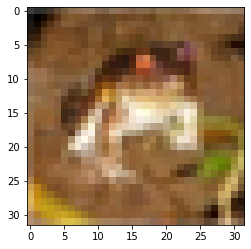

In [ ]:
#displaying one of the images
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('label: ', label)
print('label textual: ', classes[label])

In [ ]:
#Number of images belonging to each classe
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
dataset_size = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)
img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0

for i in range(dataset_size):
    img, label = dataset[i]
    img_dict[classes[label]] += 1

img_dict

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

#Preparing the data for training

In [ ]:
torch.manual_seed(43)

In [ ]:
#Split the data into validation and training
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
#Converting the data into batchs
batch_size = 64
train_loader = DataLoader(train_ds, 
                          batch_size, 
                          shuffle=True, 
                          num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, 
                        batch_size*2, 
                        num_workers=4, 
                        pin_memory=True)
test_loader = DataLoader(test_dataset, 
                         batch_size*2, 
                         num_workers=4, 
                         pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape:  torch.Size([64, 3, 32, 32])


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


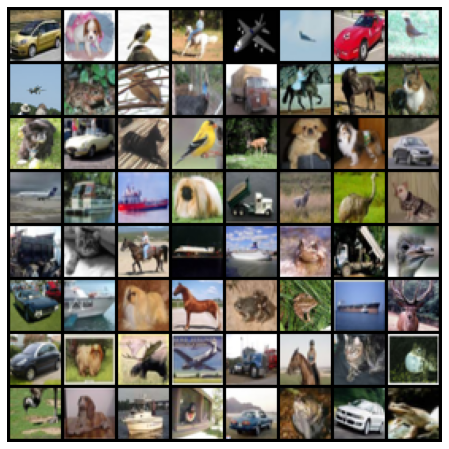

In [ ]:
#visulize the batch of data
for images, label in train_loader:
  print('images.shape: ',images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
  break

#Base model classes for training

In [ ]:
#Accuracy function to print the accuracy
def accuracy(out, labels):
  _, preds = torch.max(out, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [ ]:
#Creating the helper function class for training and evaluating the mode
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}
  
  def validation_epoch_end(self, outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  def epoch_end(self, epoch, result):
    return{'Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}'.
           format(epoch, result['val_loss'], result['val_acc'])}


In [ ]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
torch.cuda.is_available()

True

In [ ]:
#Connecting and sending data to GPU
def select_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = select_default_device()

In [ ]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    return len(self.dl)

In [ ]:
#Move data loaders to the device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

#Training the model

In [ ]:
input_size = 3*32*32
output_size = len(dataset.classes)
input_size, output_size

(3072, 10)

In [ ]:
class CIFAR10Model(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(input_size, 64)
    self.layer2 = nn.Linear(64, 32)
    self.layer3 = nn.Linear(32, 16)
    self.layer4 = nn.Linear(16, output_size)
  def forward(self, xb):
    out = xb.view(xb.size(0), -1)
    out = self.layer1(out)
    out = F.relu(out)
    out = self.layer2(out)
    out = F.relu(out)
    out = self.layer3(out)
    out = F.relu(out)
    out = self.layer4(out)
    out = F.relu(out)
    #out = F.softmax(out)
    return out

In [ ]:
model = to_device(CIFAR10Model(), device)
model

CIFAR10Model(
  (layer1): Linear(in_features=3072, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.10976562649011612, 'val_loss': 2.307469129562378}]

In [ ]:
history += fit(5, 0.01, model, train_loader, val_loader)
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
